<a href="https://colab.research.google.com/github/ramtinmk/pagerank_from_scratch/blob/main/pagerank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

- [abstract](#scrollTo=LKzTY3OktAce&line=9&uniqifier=1)
- [**Loading Stanford-Berkley Web Graph Dataset**](#scrollTo=7nDyUii6qSsw&line=1&uniqifier=1)
  - [Reducing the Number of Nodes to First 1000 Nodes](#scrollTo=677lIS7vqci_&line=1&uniqifier=1)
- [**PageRank Algorithm Implementation**](#scrollTo=DxWJz1Iha4sm&line=2&uniqifier=1)
  - [Find Eigenvectors of A](#scrollTo=9z3mLUBHhQdQ)
  - [Rewrite Eigenvector Computation Using Power Method](#scrollTo=3X6IanSOjWvw)
  - [Use NetworkX to Compute PageRank for Input Data](#scrollTo=4kibJXyDj7s-)
  - [Compare NetworkX Results with Our Implementation](#scrollTo=zoGsQP9Mp7Yv&line=1&uniqifier=1)
- [**How Changing Alpha Affects the Algorithm**](#scrollTo=L7kQSwf5Kqcz)
  - [Influence of Alpha in Terms of Random Walks and Markov Chains](#scrollTo=ljsSShw4uA3g&line=2&uniqifier=1)


# Abstract

This notebook presents an in-depth exploration of the **PageRank algorithm**, a fundamental method for ranking nodes in a directed graph. Using the **Stanford-Berkley Web Graph Dataset**, we construct an adjacency matrix for a reduced subset of **1000 nodes** and implement **three approaches** to compute PageRank:

1. **Eigenvector computation using NumPy**
2. **Power method for iterative eigenvector approximation**
3. **NetworkX’s built-in PageRank function**

We compare the results of these methods and analyze the **effect of the damping factor (alpha)** on PageRank convergence and accuracy. and then we inspect the influence of alpha in the view of random walk of the web graph.

In [ ]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# loading stanford-berkley web graph dataset

In [ ]:
!curl -O https://snap.stanford.edu/data/web-BerkStan.txt.gz
!gzip -d -f web-BerkStan.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.7M  100 18.7M    0     0  7980k      0  0:00:02  0:00:02 --:--:-- 7982k


## reducing the number of nodes to first 1000 nodes

In [ ]:
def load_limited_graph_matrix(filename, node_limit=1000):
    edges = []

    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#"):  # Skip comments
                continue
            u, v = map(int, line.split())  # Read edge (u -> v)
            if u <= node_limit and v <= node_limit:  # Filter nodes
                edges.append((u, v))

    # Create adjacency matrix for first `node_limit` nodes
    adj_matrix = np.zeros((node_limit + 1, node_limit + 1), dtype=np.uint8)

    # Fill the matrix
    for u, v in edges:
        adj_matrix[v, u] = 1  # Directed edge

    return adj_matrix

# Example usage
filename = "web-BerkStan.txt"
adj_matrix = load_limited_graph_matrix(filename, node_limit=1000)

print("Adjacency Matrix Shape:", adj_matrix.shape)
print(adj_matrix[:10, :10])  # Print a small part of the matrix


Adjacency Matrix Shape: (1001, 1001)
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 1 1 1 1 1 0 1 1]
 [0 1 0 0 0 1 0 0 0 0]
 [0 1 1 0 0 1 0 1 1 0]]


#1. pagerank algorithm implementation  



In [ ]:
def calculate_A(adj,alpha=0.8):
    # Normalize each column by its sum (size of the column)
    column_sums = np.sum(adj, axis=0)
    # Avoid division by zero
    column_sums[column_sums == 0] = adj.shape[0]  # Replace zero sums with n

    Q = adj / column_sums
    # Create a copy of Q
    P = Q.copy()

    # Number of columns in the matrix
    n = Q.shape[1]

    column_sums = np.sum(P, axis=0)

    # Change the 0 columns of Q to 1/n in P.  (No columns are changed in this case)
    P[:, np.where(column_sums==0)[0]] = 1/n
    e = np.repeat(1.0 / n, n)

    A = alpha*P + (1-alpha)*e

    return A



In [ ]:
A = calculate_A(adj_matrix)

## find eigenvectors of A

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(A)

In [ ]:
eigenvalues[0].real

0.9999999999999958

In [ ]:
%%timeit
_, _= np.linalg.eig(A)


1.84 s ± 488 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def calculate_pagerank(eigvec,eigval):
    # Find the eigenvector corresponding to the largest eigenvalue
    largest_eigenvalue_index = np.argmax(eigenvalues)
    pagerank_vector = eigenvectors[:, largest_eigenvalue_index].real

    # Normalize the pagerank vector so its elements sum to 1
    pagerank_vector = pagerank_vector / np.sum(pagerank_vector)

    return pagerank_vector

pagerank_vector = calculate_pagerank(eigenvectors,eigenvalues)

# Sort the pagerank vector in descending order and get the indices
sorted_indices = np.argsort(pagerank_vector)[::-1]

# Get the top N node IDs (e.g., top 10)
top_n = 20  # Change this to get a different number of top nodes
best_node_ids = sorted_indices[:top_n]

print("\nTop", top_n, "Node IDs with highest PageRank:")
best_node_ids



Top 20 Node IDs with highest PageRank:


array([ 40, 768, 861, 927, 372, 743, 257, 935,  33, 968, 804, 945, 715,
       720, 924, 721, 296, 330, 198,  24])

In [ ]:
pagerank_vector[best_node_ids]

array([0.03539086, 0.03135696, 0.02994036, 0.02554619, 0.01381939,
       0.01263716, 0.01212701, 0.01209029, 0.01165416, 0.01146174,
       0.01137629, 0.01122044, 0.01083457, 0.0107168 , 0.0107168 ,
       0.01066528, 0.01052931, 0.00982932, 0.0075921 , 0.00688408])

## rewrite eigenvector computation using power method


In [ ]:
# prompt: rewrite power method from scratch for A matrix

def power_method(A, num_iterations=5000,tol=1e-6):
    """
    Computes the dominant eigenvector of a matrix using the power method.
    Args:
        A: The input matrix (NumPy array).
        num_iterations: The number of iterations to perform.

    Returns:
        A tuple containing the dominant eigenvalue and its corresponding eigenvector.
    """
    n = A.shape[0]
    x = np.random.rand(n).astype(np.float128)
    x = x / np.linalg.norm(x)
    residual_history = []

    for _ in range(num_iterations):
        x_new = A @ x
        x_new = x_new / np.linalg.norm(x_new)
        if np.linalg.norm(x_new - x) < tol:
          break
        else:
          residual_history.append(np.linalg.norm(x_new - x))

        x = x_new

    eigenvalue = (x.T @ A @ x) / (x.T @ x) # Rayleigh quotient

    return eigenvalue, x,np.array(residual_history)


def power_method_pipeline(A):

    eigenvalue, eigenvector,residual_history = power_method(A,tol=1e-12)


    print("Dominant Eigenvalue (Power Method):", eigenvalue)
    print("Dominant Eigenvector (Power Method):", eigenvector)

    # Normalize the eigenvector and sort as before
    pagerank_vector_power = eigenvector / np.sum(eigenvector)

    sorted_indices_power = np.argsort(pagerank_vector_power)[::-1]
    top_n = 20
    best_node_ids_power = sorted_indices_power[:top_n]

    print("\nTop", top_n, "Node IDs with highest PageRank (Power Method):")
    print(best_node_ids_power)
    print(pagerank_vector_power[best_node_ids_power])

    return pagerank_vector_power[best_node_ids_power],best_node_ids_power,residual_history

pagerank_vector_power,best_node_ids_power,residual_history = power_method_pipeline(A)


Dominant Eigenvalue (Power Method): 0.99999999999997727046
Dominant Eigenvector (Power Method): [0.00245785 0.01081359 0.02145502 ... 0.00245785 0.00245785 0.00245785]

Top 20 Node IDs with highest PageRank (Power Method):
[ 40 768 861 927 372 743 257 935  33 968 804 945 715 924 720 721 296 330
 198  24]
[0.03539086 0.03135696 0.02994036 0.02554619 0.01381939 0.01263716
 0.01212701 0.01209029 0.01165416 0.01146174 0.01137629 0.01122044
 0.01083457 0.0107168  0.0107168  0.01066528 0.01052931 0.00982932
 0.0075921  0.00688408]


In [ ]:
%%timeit
eigenvalue, eigenvector,residual_history = power_method(A,tol=1e-12)


685 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
np.sum(A[A<0])

0.0

**plotting residual norm**

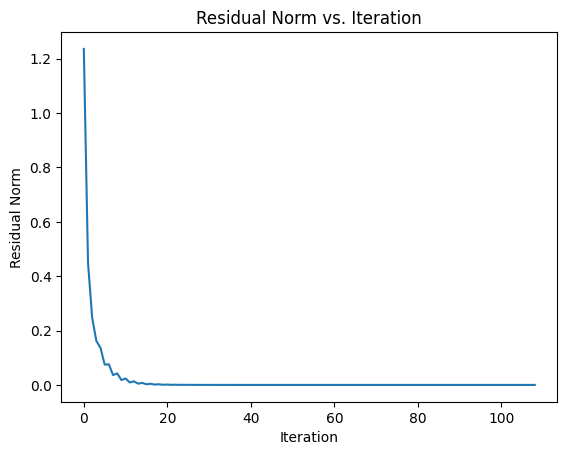

In [ ]:
plt.plot(residual_history)
plt.xlabel("Iteration")
plt.ylabel("Residual Norm")
plt.title("Residual Norm vs. Iteration")
plt.show()


## use networkx to compute pagerank for input data

In [ ]:


import networkx as nx

# Create a directed graph from the adjacency matrix
graph = nx.from_numpy_array(adj_matrix.T, create_using=nx.DiGraph)

# Compute PageRank
pagerank = nx.pagerank(graph, alpha=0.8,max_iter=1000,tol=1e-8)

# Get the top N nodes with the highest PageRank
top_n = 20
sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
top_nodes = sorted_pagerank[:top_n]

print("\nTop", top_n, "Node IDs with highest PageRank (NetworkX):")
for node, rank in top_nodes:
    print(f"Node: {node}, PageRank: {rank}")

nx_pagerank = np.array([i[1] for i in sorted_pagerank])[:20]
nx_topnodes =[i[0] for i in sorted_pagerank]
nx_topnodes = np.array(nx_topnodes)[:20]



Top 20 Node IDs with highest PageRank (NetworkX):
Node: 40, PageRank: 0.03539090228443072
Node: 768, PageRank: 0.03135807666251803
Node: 861, PageRank: 0.029934884200386317
Node: 927, PageRank: 0.02554714185940218
Node: 372, PageRank: 0.013819601121699688
Node: 743, PageRank: 0.012637492822028338
Node: 257, PageRank: 0.012127121464230214
Node: 935, PageRank: 0.012090615615107056
Node: 33, PageRank: 0.011654446678630205
Node: 968, PageRank: 0.011462043919932382
Node: 804, PageRank: 0.01137660892814272
Node: 945, PageRank: 0.011220739827072918
Node: 715, PageRank: 0.010834861575302114
Node: 720, PageRank: 0.010717090479982429
Node: 924, PageRank: 0.010717090479982429
Node: 721, PageRank: 0.010665565633318311
Node: 296, PageRank: 0.010529510885075083
Node: 330, PageRank: 0.00982951078045965
Node: 198, PageRank: 0.007592219240596845
Node: 24, PageRank: 0.006884124207159345


In [ ]:
# def draw_graph(G):
#     plt.figure(figsize=(25, 25))
#     pos = nx.spring_layout(G)
#     nx.draw(G, pos, with_labels=False, node_size=300, arrows=True)
#     plt.title("Directed Graph from Adjacency Matrix")
#     plt.show()

# draw_graph(graph)

## compare networkx results with our implementation

**checking if all nodes are in correct order in the top 20 nodes**


In [ ]:
print(np.allclose(best_node_ids==nx_topnodes,np.ones(20))) #.eig method rank
print(np.allclose(best_node_ids_power==nx_topnodes,np.ones(20))) #power method ranking (node 924 and 720 are not in correct order because of percision)

True
False


In [ ]:
nx_topnodes,best_node_ids_power

(array([ 40, 768, 861, 927, 372, 743, 257, 935,  33, 968, 804, 945, 715,
        720, 924, 721, 296, 330, 198,  24]),
 array([ 40, 768, 861, 927, 372, 743, 257, 935,  33, 968, 804, 945, 715,
        924, 720, 721, 296, 330, 198,  24]))

**calculating the norm of difference between top 20 nodes pagerank scores**

In [ ]:
print(np.linalg.norm(nx_pagerank-pagerank_vector_power))
print(np.linalg.norm(nx_pagerank-pagerank_vector[best_node_ids]))

5.7605205456699588787e-06
5.760520553948028e-06


# how changing alpha effects the algorithm

Dominant Eigenvalue (Power Method): 0.9999999999999176374
Dominant Eigenvector (Power Method): [0.02634193 0.0309493  0.03116275 ... 0.02634193 0.02634193 0.02634193]

Top 20 Node IDs with highest PageRank (Power Method):
[ 40 861 768 372 257 927  24 296 510 330 613 693 460 565 426 743  33 198
 233 161]
[0.01106892 0.00461092 0.00434856 0.00315297 0.00286252 0.00285418
 0.00280799 0.00264139 0.00256341 0.00254239 0.00244325 0.00238006
 0.00224917 0.00224401 0.00213643 0.00211453 0.00209267 0.00203854
 0.00191524 0.00191051]
Alpha: 0.1, Difference in top nodes: 3.8430449709678556e-08
Dominant Eigenvalue (Power Method): 1.0000000000000544557
Dominant Eigenvector (Power Method): [0.01997819 0.02739544 0.0285063  ... 0.01997819 0.01997819 0.01997819]

Top 20 Node IDs with highest PageRank (Power Method):
[ 40 861 768 372 927 257  24 296 330 510 613 693 460 565 743  33 426 198
 233 161]
[0.01983372 0.00770448 0.00767156 0.00512741 0.00485291 0.00456236
 0.00436957 0.00414053 0.00394464 0.00

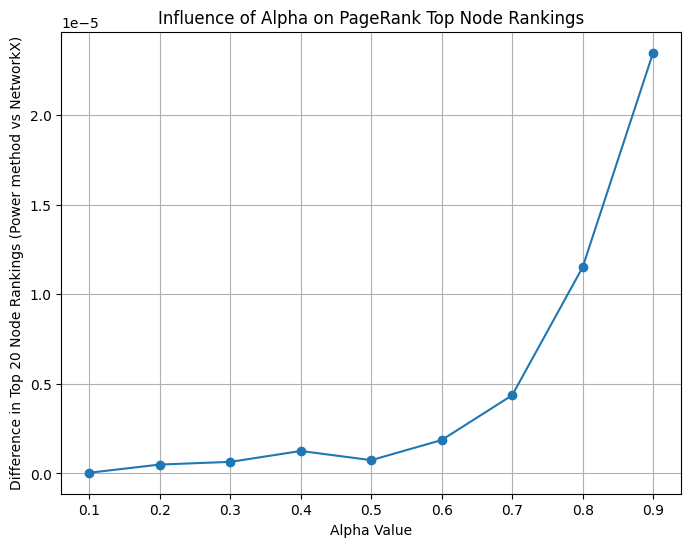

In [ ]:


alpha_values = np.linspace(0.1, 0.9, 9)  # Example alpha values
pagerank_differences = []

for alpha in alpha_values:
    # Compute PageRank using NetworkX with the current alpha
    pagerank = nx.pagerank(graph, alpha=alpha, max_iter=1000, tol=1e-8)
    # Get the top N nodes with the highest PageRank
    top_n = 20
    sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
    top_nodes_nx = [node for node, rank in sorted_pagerank[:top_n]]
    top_ranks_nx = [rank for node, rank in sorted_pagerank[:top_n]]

    # Compute PageRank using your power method with the current alpha
    A = calculate_A(adj_matrix,alpha=alpha)
    pagerank_vector_power,_,_ = power_method_pipeline(A)

    # Calculate the difference in top node rankings
    difference = np.sum(np.abs(np.array(top_ranks_nx) - np.array(pagerank_vector_power)))
    pagerank_differences.append(difference)

    print(f"Alpha: {alpha:.1f}, Difference in top nodes: {difference}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, pagerank_differences, marker='o')
plt.xlabel("Alpha Value")
plt.ylabel("Difference in Top 20 Node Rankings (Power method vs NetworkX)")
plt.title("Influence of Alpha on PageRank Top Node Rankings")
plt.grid(True)
plt.show()


When the norm of the rank differences increases with alpha, it can be an indication that the power method is facing more numerical challenges. Here are a few points to consider:

- Spectral Gap Reduction:

  As alpha increases, the damping factor approaches 1, which means the matrix you're applying the power method to becomes closer to a rank-one perturbation of the original stochastic matrix. This typically reduces the spectral gap (the difference between the dominant eigenvalue and the second-largest eigenvalue), making convergence slower and more sensitive to numerical errors.

- Sensitivity to Perturbations:

  A smaller spectral gap means that any numerical inaccuracies (round-off errors, for example) can have a larger impact on the computed eigenvector. This may lead to discrepancies in the ranking of nodes when compared to a more robust implementation (like NetworkX's PageRank).

- Method Implementation Differences:

  NetworkX's built-in PageRank likely incorporates additional stabilization techniques or optimized numerical methods that can mitigate these issues. Thus, if you see an increased norm of differences in rankings for higher alpha values, it might suggest that your power method implementation is less robust under these conditions.

So, while the increased difference norm doesn't definitively prove that the power method is "less numerically stable" overall, it does suggest that its performance and accuracy are more sensitive at higher alpha values due to the inherent properties of the underlying matrix. Adjusting convergence tolerances, improving the numerical precision, or using alternative methods could help mitigate these effects.

## Influence of Alpha in Terms of Random Walks and Markov Chains

The damping factor **alpha (α)** in the PageRank algorithm controls the balance between two behaviors in a **random walk** interpretation:

1. **Following a link (with probability α):**  
   A web surfer randomly follows an outgoing link from the current node.
   
2. **Jumping to a random node (with probability 1 - α):**  
   Instead of following a link, the surfer randomly teleports to any node in the graph.

From a **Markov chain perspective**, the PageRank matrix **A** is a modified transition matrix where teleportation ensures the chain remains **ergodic (irreducible and aperiodic)**, guaranteeing convergence to a unique stationary distribution.  

### Effect of Increasing Alpha:

- As **α → 1**, the Markov chain behaves more like a **pure random walk**, relying primarily on the link structure. This increases the influence of **highly connected subgraphs**, leading to slower convergence (due to a smaller spectral gap).
- As **α → 0**, the Markov chain increasingly **resembles a uniform random jump process**, making PageRank values more evenly distributed across nodes.
- A **higher α reduces the mixing rate** of the Markov chain, meaning it takes longer for the random walk to stabilize to its stationary distribution. This explains why the **power method's convergence slows down for large α**, and small numerical errors can accumulate over iterations.

### Trade-offs in Choosing Alpha:

- A typical value of **α = 0.85** is chosen in practice, as it maintains a good balance between **following the link structure** and **ensuring convergence**.
- Lower values of α can reduce the effect of link spam and increase numerical stability but may dilute the importance of highly connected nodes.
- Higher values of α make rankings more dependent on link structures but increase the risk of slow convergence and numerical instability.

This connection to **random walks and Markov chains** helps explain why the norm of ranking differences **increases with α**, as seen in the experiments. The reduced spectral gap at high α values makes the power method more sensitive to perturbations, leading to greater deviations in ranking results compared to the more stable NetworkX implementation.


**Question 2**

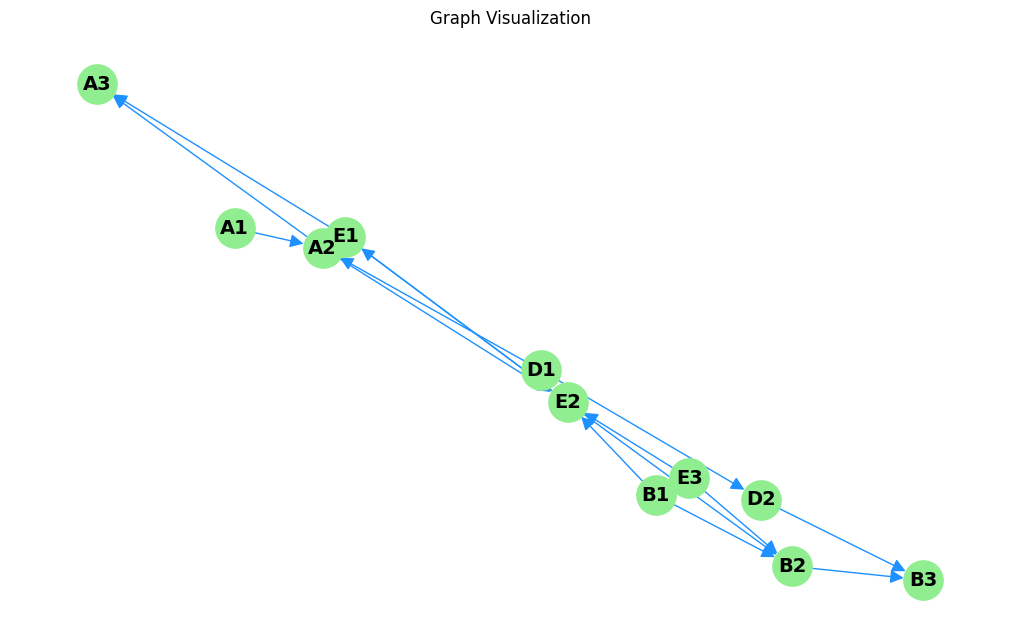

In [ ]:
G = nx.DiGraph()
edges = [
    ("A1", "A2"),
    ("D1", "D2"),
    ("D1", "A2"),
    ("A2", "E2"),
    ("A2", "A3"),
    ("E2", "E1"),
    ("E1", "A3"),
    ("E1", "E2"),
    ("E2", "B2"),
    ("B1", "E2"),
    ("E3", "E2"),
    ("E3", "B2"),
    ("B1", "B2"),
    ("B2", "B3"),
    ("D2", "B3"),
]

G.add_edges_from(edges)
# Draw graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightgreen", font_size=14, font_weight='bold', arrowsize=20, edge_color="dodgerblue")
plt.title("Graph Visualization")
plt.show()

In [ ]:
nodelist=["A1", "A2", "A3", "B1", "B2", "B3", "E1", "E2", "D1", "D2"]
matrix = nx.to_numpy_array(G, nodelist).T
print(matrix)
G = nx.from_numpy_array(matrix.T, create_using=nx.DiGraph)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [ ]:
A1 = calculate_A(matrix)
print(A1.shape)
res,ids,_ = power_method_pipeline(A1)
print(res)

best_node_names = [nodelist[i] for i in ids]
best_node_names

(10, 10)
Dominant Eigenvalue (Power Method): 1.0000000000001918167
Dominant Eigenvector (Power Method): [0.13100788 0.28821734 0.36557438 0.13100788 0.35060205 0.55821835
 0.2981989  0.41797753 0.13100788 0.18341104]

Top 20 Node IDs with highest PageRank (Power Method):
[5 7 2 4 6 1 9 8 3 0]
[0.19550778 0.14639049 0.12803706 0.12279322 0.10443978 0.10094389
 0.06423702 0.04588359 0.04588359 0.04588359]
[0.19550778 0.14639049 0.12803706 0.12279322 0.10443978 0.10094389
 0.06423702 0.04588359 0.04588359 0.04588359]


['B3', 'E2', 'A3', 'B2', 'E1', 'A2', 'D2', 'D1', 'B1', 'A1']

In [ ]:
pagerank = nx.pagerank(G, alpha=0.8,max_iter=1000,tol=1e-8)


sorted_pagerank = sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
top_nodes = sorted_pagerank[:]

print("Node IDs sort based on highest PageRank:")
top_nodes

Node IDs sort based on highest PageRank:


[(5, 0.19550777853358578),
 (7, 0.14639049071456486),
 (2, 0.128037055356986),
 (4, 0.12279321818264563),
 (6, 0.10443978282506677),
 (1, 0.1009438926641037),
 (9, 0.06423702194894595),
 (0, 0.045883586591367105),
 (3, 0.045883586591367105),
 (8, 0.045883586591367105)]